# Importing Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# Loading the datasets

In [2]:
transform = transforms.ToTensor()

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 167041166.94it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 122112594.58it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34279341.35it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4255199.64it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Device Configuration

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Hyperparameters

In [4]:
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCH = 20

# Load the Data using DataLoader

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# AutoEncoder Model

In [6]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, stride=(1,1),kernel_size=(3,3), padding=1), # 28x28x1 -> 28x28x32
            nn.LeakyReLU(0.01),
            nn.Conv2d(32, 64, stride=(2,2),kernel_size=(3,3), padding=1), # 28x28x32 -> 14x14x64
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 64, stride=(2,2),kernel_size=(3,3), padding=1), # 14x14x64 -> 7x7x64
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 64, stride=(1,1),kernel_size=(3,3), padding=1), # 7x7x64 -> 7x7x64
            nn.Flatten(),
            nn.Linear(3136, 10) # 3136 -> 10
        )

        self.decoder = nn.Sequential(
            nn.Linear(10, 3136),   # 10 -> 3136
            Reshape(-1, 64, 7, 7),  # 3136 -> 7x7x64
            nn.ConvTranspose2d(64, 64, stride=(1,1),kernel_size=(3,3), padding=1),  # 7x7x64 -> 7x7x64
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(64, 64, stride=(2,2),kernel_size=(3,3), padding=1), # 7x7x64 -> 14x14x64
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(64, 32, stride=(2,2),kernel_size=(3,3), padding=0), # 14x14x64 -> 29x29x32
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(32, 1, stride=(1,1),kernel_size=(3,3), padding=0),  # 29x29x32 -> 29x29x1
            Trim(),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def test():
    x = torch.randn(32, 1, 28, 28)
    model = AutoEncoder()
    preds = model(x)
    assert preds.shape == x.shape

test()

# Define Loss function, Optimizer and Initializiing the Model

In [7]:
loss = nn.MSELoss()
model = AutoEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Model Training

In [8]:
train_loss = []
test_loss = []

def train(model, optimizer, loss_fn, trainloader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(trainloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss_value = loss_fn(outputs, inputs)
        loss_value.backward()
        optimizer.step()

        running_loss += loss_value.item()

    train_loss.append(running_loss / len(trainloader))
    print(f"Training | Loss: {running_loss / len(trainloader)}")

def test(model, loss_fn, testloader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss_value = loss_fn(outputs, inputs)

            running_loss += loss_value.item()
    test_loss.append(running_loss / len(testloader))
    print(f"Testing | Loss: {running_loss / len(testloader)}")

# Training loop
for epoch in range(EPOCH):
    print(f"EPOCH {epoch + 1}")
    train(model, optimizer, loss, train_loader, device)
    test(model, loss, test_loader, device)

EPOCH 1


Training: 100%|██████████| 1875/1875 [00:28<00:00, 66.80it/s] 


Training | Loss: 0.03176568458775679


Testing: 100%|██████████| 313/313 [00:01<00:00, 172.15it/s]


Testing | Loss: 0.01734242088104875
EPOCH 2


Training: 100%|██████████| 1875/1875 [00:16<00:00, 111.98it/s]


Training | Loss: 0.01622338567475478


Testing: 100%|██████████| 313/313 [00:01<00:00, 184.67it/s]


Testing | Loss: 0.014931782842063295
EPOCH 3


Training: 100%|██████████| 1875/1875 [00:16<00:00, 115.04it/s]


Training | Loss: 0.014682684096197288


Testing: 100%|██████████| 313/313 [00:01<00:00, 182.49it/s]


Testing | Loss: 0.01406277560840209
EPOCH 4


Training: 100%|██████████| 1875/1875 [00:17<00:00, 107.58it/s]


Training | Loss: 0.013844329560299714


Testing: 100%|██████████| 313/313 [00:01<00:00, 185.06it/s]


Testing | Loss: 0.013778189872614682
EPOCH 5


Training: 100%|██████████| 1875/1875 [00:16<00:00, 116.19it/s]


Training | Loss: 0.013270781357089678


Testing: 100%|██████████| 313/313 [00:01<00:00, 167.00it/s]


Testing | Loss: 0.013021377769236366
EPOCH 6


Training: 100%|██████████| 1875/1875 [00:16<00:00, 112.57it/s]


Training | Loss: 0.012856179456412792


Testing: 100%|██████████| 313/313 [00:01<00:00, 178.07it/s]


Testing | Loss: 0.01286551477119755
EPOCH 7


Training: 100%|██████████| 1875/1875 [00:16<00:00, 117.11it/s]


Training | Loss: 0.012551511167983214


Testing: 100%|██████████| 313/313 [00:01<00:00, 184.83it/s]


Testing | Loss: 0.012390652067435625
EPOCH 8


Training: 100%|██████████| 1875/1875 [00:16<00:00, 113.61it/s]


Training | Loss: 0.012284471306204796


Testing: 100%|██████████| 313/313 [00:01<00:00, 181.03it/s]


Testing | Loss: 0.01226409784586618
EPOCH 9


Training: 100%|██████████| 1875/1875 [00:16<00:00, 116.13it/s]


Training | Loss: 0.01208842296699683


Testing: 100%|██████████| 313/313 [00:01<00:00, 180.58it/s]


Testing | Loss: 0.012250095329131372
EPOCH 10


Training: 100%|██████████| 1875/1875 [00:16<00:00, 112.83it/s]


Training | Loss: 0.011894691005597513


Testing: 100%|██████████| 313/313 [00:01<00:00, 180.39it/s]


Testing | Loss: 0.012086270433573867
EPOCH 11


Training: 100%|██████████| 1875/1875 [00:16<00:00, 115.72it/s]


Training | Loss: 0.011755214580645164


Testing: 100%|██████████| 313/313 [00:01<00:00, 179.64it/s]


Testing | Loss: 0.011908241413747921
EPOCH 12


Training: 100%|██████████| 1875/1875 [00:16<00:00, 112.45it/s]


Training | Loss: 0.01161184839308262


Testing: 100%|██████████| 313/313 [00:01<00:00, 182.94it/s]


Testing | Loss: 0.011887383119116862
EPOCH 13


Training: 100%|██████████| 1875/1875 [00:16<00:00, 116.56it/s]


Training | Loss: 0.011488893782595794


Testing: 100%|██████████| 313/313 [00:01<00:00, 183.67it/s]


Testing | Loss: 0.011696694209017217
EPOCH 14


Training: 100%|██████████| 1875/1875 [00:16<00:00, 113.07it/s]


Training | Loss: 0.011373533628632625


Testing: 100%|██████████| 313/313 [00:01<00:00, 183.10it/s]


Testing | Loss: 0.011769245790775876
EPOCH 15


Training: 100%|██████████| 1875/1875 [00:16<00:00, 110.68it/s]


Training | Loss: 0.011284075942138832


Testing: 100%|██████████| 313/313 [00:01<00:00, 178.07it/s]


Testing | Loss: 0.011606620480351078
EPOCH 16


Training: 100%|██████████| 1875/1875 [00:16<00:00, 110.41it/s]


Training | Loss: 0.011185268004486958


Testing: 100%|██████████| 313/313 [00:01<00:00, 184.14it/s]


Testing | Loss: 0.011732201844739457
EPOCH 17


Training: 100%|██████████| 1875/1875 [00:16<00:00, 116.84it/s]


Training | Loss: 0.011121725810567537


Testing: 100%|██████████| 313/313 [00:01<00:00, 182.41it/s]


Testing | Loss: 0.011573751336528947
EPOCH 18


Training: 100%|██████████| 1875/1875 [00:16<00:00, 111.70it/s]


Training | Loss: 0.011023060276856025


Testing: 100%|██████████| 313/313 [00:01<00:00, 175.34it/s]


Testing | Loss: 0.011431153075168498
EPOCH 19


Training: 100%|██████████| 1875/1875 [00:16<00:00, 115.37it/s]


Training | Loss: 0.010980194933712483


Testing: 100%|██████████| 313/313 [00:01<00:00, 173.92it/s]


Testing | Loss: 0.011559063955522574
EPOCH 20


Training: 100%|██████████| 1875/1875 [00:17<00:00, 108.77it/s]


Training | Loss: 0.010890926301976045


Testing: 100%|██████████| 313/313 [00:01<00:00, 182.87it/s]

Testing | Loss: 0.01133007238419673


# Plotting Loss

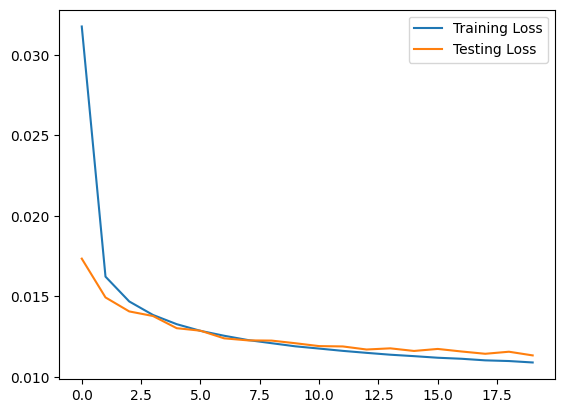

In [9]:
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

# Plot Generated Image

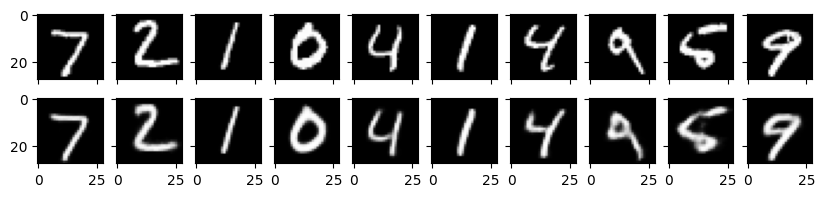

In [10]:
def plot_generated_images(data_loader,model,n_images=10):
    fig, axes = plt.subplots(nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(n_images,2))
    for idx, (input, _) in enumerate(data_loader):
        input = input.to(device)
        input = input[:n_images]
        reconstruction = model(input)
        for i in range(n_images):
            axes[0,i].imshow(input[i].cpu().detach().reshape((28,28)), cmap='gray')
            axes[1,i].imshow(reconstruction[i].cpu().detach().reshape((28,28)), cmap='gray')
        break

plot_generated_images(test_loader,model)
